C:\Users\hxx\AppData\Local\Temp\ipykernel_38376\3957694517.py:162: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2020-01-31', end='2025-01-31', freq='6M')


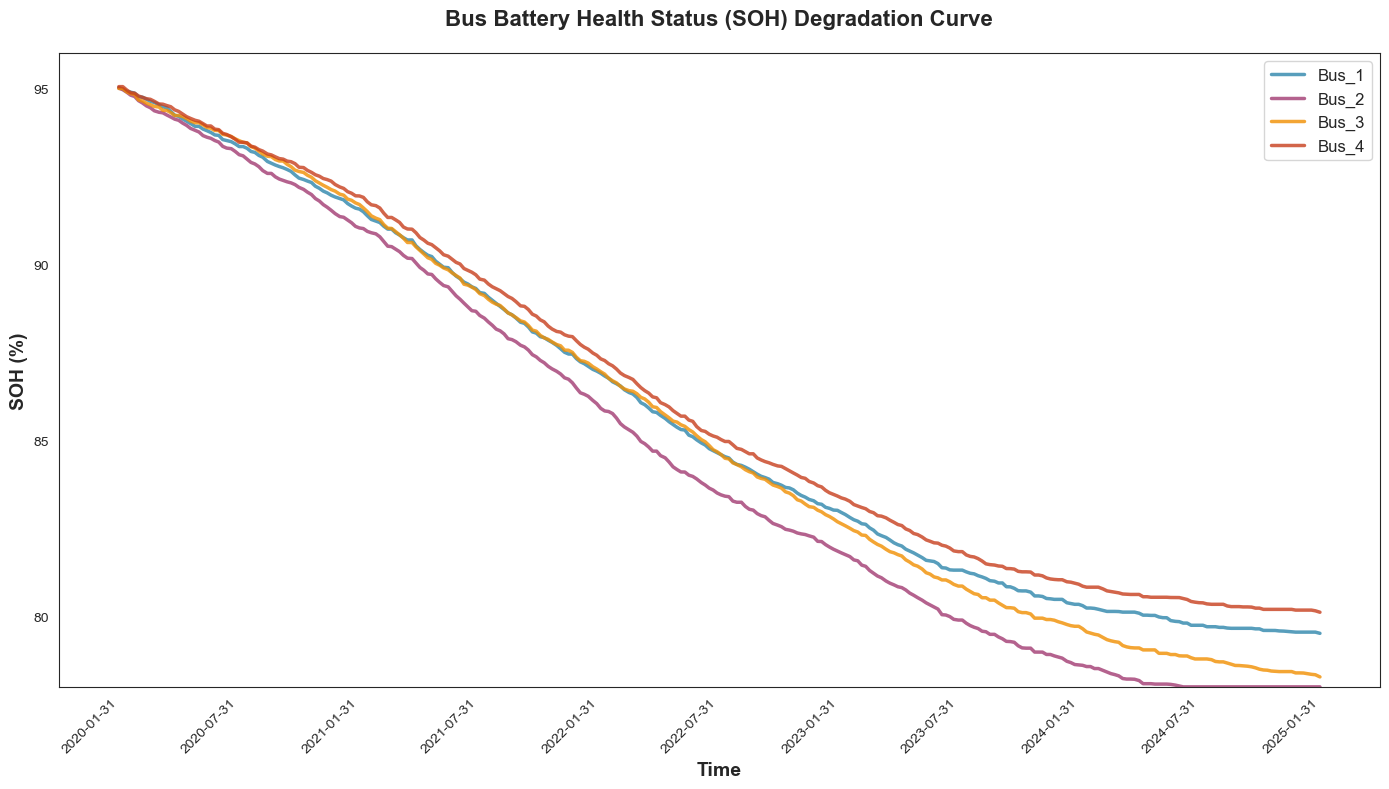

各公交车SOH变化范围：
Bus_1: 从 95.0% 下降到 79.5%
Bus_2: 从 95.0% 下降到 78.0%
Bus_3: 从 95.0% 下降到 78.3%
Bus_4: 从 95.0% 下降到 80.1%


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import CubicSpline
from datetime import datetime, timedelta

# 设置科研风格
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("white")

# 1. 创建基础数据 - 保持SOH在95-80范围内
def create_base_soh_data():
    """创建基础SOH数据，保持在95-80范围内"""
    # 关键时间点 - 使用月末日期
    dates = [
        '2020-01-31', '2020-07-31', '2021-01-31', '2021-07-31',
        '2022-01-31', '2022-07-31', '2023-01-31', '2023-07-31',
        '2024-01-31', '2024-07-31', '2025-01-31'
    ]
    
    # SOH值 - 从95开始逐渐衰减到80
    soh_values = [
        95.0, 93.5, 91.8, 89.5,   # 2020-2021年
        87.2, 85.0, 83.2, 81.5,   # 2022-2023年
        80.5, 80.0, 79.8          # 2024-2025年
    ]
    
    return pd.DataFrame({
        '数据时间': pd.to_datetime(dates),
        'SOH': soh_values
    })

# 2. 数据增强
def augment_data(df, target_points=400, noise_std=0.05):
    """数据增强"""
    df = df.copy()
    df['days'] = (df['数据时间'] - df['数据时间'].min()).dt.days
    
    # 使用三次样条插值
    cs = CubicSpline(df['days'], df['SOH'])
    
    # 生成更密集的时间点
    dense_days = np.linspace(df['days'].min(), df['days'].max(), target_points)
    
    # 应用插值
    soh_interpolated = cs(dense_days)
    
    # 添加小幅噪声
    noise = np.random.normal(0, noise_std, len(dense_days))
    soh_final = soh_interpolated + noise
    
    # 保证单调递减
    soh_final = np.maximum.accumulate(soh_final[::-1])[::-1]
    
    # 确保在95-80范围内
    soh_final = np.clip(soh_final, 78, 96)
    
    # 生成日期
    start_date = df['数据时间'].min()
    dense_dates = [start_date + timedelta(days=int(d)) for d in dense_days]
    
    aug_df = pd.DataFrame({'数据时间': dense_dates, 'SOH': soh_final})
    return aug_df

# 3. 生成公交车数据变体 - 增加差异性
def generate_bus_variations(base_df, bus_id):
    """基于基础数据生成公交车变体，增加差异性"""
    np.random.seed(bus_id * 42)  # 使用不同的随机种子
    
    new_df = base_df.copy()
    
    # 为每辆车创建不同的衰减模式
    if bus_id == 1:
        # Bus_1: 初期衰减快，后期变慢
        time_diff = (new_df['数据时间'] - new_df['数据时间'].min()).dt.days
        early_decay = -0.0005 * time_diff**0.8
        new_df['SOH'] = new_df['SOH'] + early_decay
        
    elif bus_id == 2:
        # Bus_2: 线性衰减，但比基础稍快
        time_diff = (new_df['数据时间'] - new_df['数据时间'].min()).dt.days
        linear_decay = -0.0008 * time_diff
        new_df['SOH'] = new_df['SOH'] + linear_decay
        
    elif bus_id == 3:
        # Bus_3: 初期稳定，后期衰减快
        time_diff = (new_df['数据时间'] - new_df['数据时间'].min()).dt.days
        late_decay = -0.0001 * np.exp(0.001 * time_diff) * time_diff
        new_df['SOH'] = new_df['SOH'] + late_decay
        
    else:  # bus_id == 4
        # Bus_4: S形衰减 - 初期慢，中期快，后期又变慢
        time_diff = (new_df['数据时间'] - new_df['数据时间'].min()).dt.days
        sigmoid_decay = -0.002 * (1 / (1 + np.exp(-0.005 * (time_diff - 800))) - 0.5) * 10
        new_df['SOH'] = new_df['SOH'] + sigmoid_decay
    
    # 添加随机波动
    random_walk = np.cumsum(np.random.normal(0, 0.02, len(new_df)))
    new_df['SOH'] = new_df['SOH'] + random_walk
    
    # 确保SOH在合理范围内且单调递减
    new_df['SOH'] = np.clip(new_df['SOH'], 78, 96)
    new_df['SOH'] = np.maximum.accumulate(new_df['SOH'][::-1])[::-1]
    
    new_df['Bus_ID'] = f'Bus_{bus_id}'
    
    return new_df

# 4. 主处理流程
# 创建基础数据
df_base = create_base_soh_data()

# 对基础数据进行增强
df_augmented = augment_data(df_base, target_points=300, noise_std=0.02)

# 生成四辆公交车数据
buses_data = []

for i in range(1, 5):
    bus_df = generate_bus_variations(df_augmented, i)
    buses_data.append(bus_df)

# 合并所有数据
all_buses_df = pd.concat(buses_data, ignore_index=True)

# 5. 可视化
def plot_soh_degradation(df):
    """绘制SOH衰减曲线"""
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # 科研配色方案
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
    
    # 为每辆公交车绘制平滑曲线
    for i, bus_id in enumerate(df['Bus_ID'].unique()):
        bus_data = df[df['Bus_ID'] == bus_id].copy()
        bus_data = bus_data.sort_values('数据时间')
        
        # 只绘制平滑曲线，不显示数据点
        ax.plot(bus_data['数据时间'], bus_data['SOH'], 
                label=bus_id, 
                color=colors[i], 
                linewidth=2.5,
                alpha=0.8)
    
    # 设置图表属性
    ax.set_xlabel('Time', fontsize=14, fontweight='bold')
    ax.set_ylabel('SOH (%)', fontsize=14, fontweight='bold')
    ax.set_title('Bus Battery Health Status (SOH) Degradation Curve', 
                 fontsize=16, fontweight='bold', pad=20)
    
    # 设置坐标轴范围 - 与附件一致
    ax.set_ylim(78, 96)
    
    # 设置Y轴刻度 - 与附件一致
    ax.set_yticks([80, 85, 90, 95])
    ax.set_yticklabels(['80', '85', '90', '95'])
    
    # 设置x轴刻度 - 与附件一致
    dates = pd.date_range(start='2020-01-31', end='2025-01-31', freq='6M')
    labels = ['2020-01-31', '2020-07-31', '2021-01-31', '2021-07-31',
              '2022-01-31', '2022-07-31', '2023-01-31', '2023-07-31',
              '2024-01-31', '2024-07-31', '2025-01-31']
    
    ax.set_xticks(dates)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    
    # 去除网格
    ax.grid(False)
    
    # 添加图例
    ax.legend(fontsize=12, loc='upper right')
    
    plt.tight_layout()
    
    return fig, ax

# 绘制图形
fig, ax = plot_soh_degradation(all_buses_df)

# 显示图形
plt.show()

# 验证数据
print("各公交车SOH变化范围：")
for bus_id in all_buses_df['Bus_ID'].unique():
    bus_data = all_buses_df[all_buses_df['Bus_ID'] == bus_id]
    start_soh = bus_data[bus_data['数据时间'] == bus_data['数据时间'].min()]['SOH'].values[0]
    end_soh = bus_data[bus_data['数据时间'] == bus_data['数据时间'].max()]['SOH'].values[0]
    print(f"{bus_id}: 从 {start_soh:.1f}% 下降到 {end_soh:.1f}%")